In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lec_act_4_fitting.ipynb")

# Fit a line to the middle part of the finger 1 motor positions

Slides for this lecture activity: https://docs.google.com/presentation/d/1NtoXYbl2nq1dkIU0KQE8ogjSCfb22wgLigY3JJpHHGI/edit?usp=sharing

Lecture goals:
- Extract a subset of data based on conditions
- Use linregress to approximate linear data

The data we're using is from a robot grasping trial. It is the motor position from the start of the grasp to the end for one finger. If the grasp was successful, then the motor tends to stop early (since the finger does not close all the way). If the grasp was unsuccessful, the finger (usually, but not always) closes all the way. The data analysis question is: can we tell the difference between the two? 

To do this, we're going to find where the motor starts closing the finger, and where it stops, then fit a line to that "middle" bit of data. We'll then plot the data for successful versus unsuccessful grasps and see if it looks different.

In [2]:
# Doing the imports for you
import numpy as np
import json as json
from scipy.stats import linregress
import matplotlib.pyplot as plt

## Read the motor position data in

The motor position data is in **Motor position f1.csv** in the Data directory. 

The shape of the data should be (660, 40). The "successful" ones are the first 355, the unsuccesful ones are from 355 to 660.

The data was sampled at 30Hz. Each column is the motor position value at each time step.

Each row is a grasp.

TODO: Read the data in and make a plot of a couple examples to see what it looks like


In [3]:

# TODO Read in Motor position f1.csv file. Reminder that loadtxt can take an optional delimiter parameter
#  Make sure you capitalize the Data directory and the filename the same as they are in the explorer pane on the left
data_all = np.loadtxt('Data/Motor position f1.csv', dtype='float', delimiter=',')  # Motor position f1.csv

# TODO: Check that the data is 660 by 40
assert data_all.shape == (660, 40)

In [4]:
# We need t values to go with the y values; the t values are all the same for every row, so just make once
#   Reminder: the data is sampled at 30Hz. So each sample should be 1/30th of a second apart

# TODO: Create ts, a numpy array that starts at 0, has the same number of elements as data_all's columns, and 
#   is of the form: 0, 1/30, 2/30 etc

# Know time step
time_step = 1/30

# TODO Create ts. numpy's arange is handy here...
ts = np.arange(data_all.shape[1])/30

# Check that ts is correct
assert ts.size == data_all.shape[1]
assert ts[0] == 0
assert ts[-1] == (data_all.shape[1] - 1) * time_step

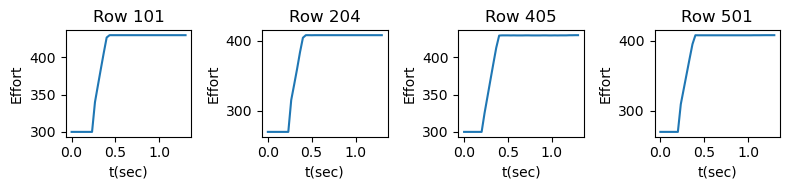

In [5]:
# Plot a few of the rows to see what the data looks like
n_rows = 1
n_cols = 4
fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(8, 2))


# TODO Pick 4 examples to plot. Use your ts values from above. You do not need to
#   use the ones from the slides, but you should but the example number in the title
# Don't forget to label the x and y axes
# plot data 101
axs1[0].plot(ts, data_all[101, :])
#set title, xlabel, ylabel
axs1[0].set_title('Row 101')
axs1[0].set_xlabel('t(sec)')
axs1[0].set_ylabel('Effort')
# plot data 204
axs1[1].plot(ts, data_all[204, :])
# set title, xlabel, ylabel
axs1[1].set_title('Row 204')
axs1[1].set_xlabel('t(sec)')
axs1[1].set_ylabel('Effort')
# plot data 405
axs1[2].plot(ts, data_all[405, :])
# set title, xlabel, ylabel
axs1[2].set_title('Row 405')
axs1[2].set_xlabel('t(sec)')
axs1[2].set_ylabel('Effort')
# plot data 501
axs1[3].plot(ts, data_all[501, :])
# set title, xlabel, ylabel
axs1[3].set_title('Row 501')
axs1[3].set_xlabel('t(sec)')
axs1[3].set_ylabel('Effort')


plt.tight_layout()


In [6]:
grader.check("Read data")

Read data results: All test cases passed!

## Fit a line to the middle points

Doing this as a function so you can re-use the code

Some decisions:
- Pass in the data as two arrays, the t and y values
-    Use **fit_line_to_middle_bit** function to pull out the "middle" bit
- Returns the points of intersection with the min/max values, the slope, and error of the fit because in the long run that's what we care about (where the motor started and stopped)
- The eps is a "fudge factor" so that you can clip out data above/below a threshhold

How to do this:
- Clip with a fudge factor, use np.logical_and fudge factor should be d_y = eps * (y_max - y_min), 
   take all points y_min + d_y < y < y_max - dy
- Use np.where to find the first index where y > y_min + d_y (or < y_max - d_y)
-    np.where returns a tuple of arrays; use index[0][0] to get the value out
-       index[0] gets the array out of the tuple, index[0][0] gets the first element of the array
- Then use start:end to get the values out of ts, ys
- Reminder that there is a tutorial on np.where in week 2

Alternative "fancy" approach (requires use of logical and):
- Get a boolean array with true where y > y_min + d_y AND y < y_max - d_y
- Use the boolean array to index the ts and the ys


In [7]:
# EXAMPLE CODE
#  Using np.where to find an index in another array
#  Using np.logical_and to get "this and that"

n_data_pts = 10
# t values
ts_example = np.linspace(0, np.pi * 2, n_data_pts)
# Cosine - is negative in the middle
ys_example = np.cos(ts_example)

# Find the y values that are between -0.1 and -1.0 - ok, we know cosine values don't go below -1, but this is just an example...
b_is_below_first_value = ys_example < -0.1     # first condition
b_is_above_second_value = ys_example >= -1.0   # second condition
b_is_both = np.logical_and(b_is_below_first_value, b_is_above_second_value)  # Does the same thing as the line below
b_is_both = b_is_below_first_value & b_is_above_second_value  # Is true only for middle points (check in variable window)
res_where = np.where(b_is_both)

# Remember that res_where is a tuple - get the first element of the tuple (the indices)
res_where_indices = res_where[0]

# Now get the *first* index where the condition is true
first_index = res_where_indices[0]

# Now get the corresponding t value
first_t = ts_example[first_index]

# Note that for the function you'll do a linear regression and use the slope to find the corresponding t value

print(f"Found first value {ys_example[first_index]} at index {first_index}, t value {first_t}")

Found first value -0.4999999999999998 at index 3, t value 2.0943951023931953


In [8]:
# SCRATCH CELL
# Write the code here before putting it in the function

# This bit of code will test your function with known values - should print out ((0.25, 0.0), (0.75, 1.0))
# The index slice to use is 3:6 (the y values 0.25, 0.5, 0.75  and t values of 0.375, 0.5, 0.625)
#   Check the indices you get back from np.where - should select the three values that are NOT 0 or 1
# Slope is 2.0, intercept is -0.5
xs = np.linspace(0, 1, 9)
ys = np.array([0, 0, 0, 0.25, 0.5, 0.75, 1, 1, 1])

print(f"X values are {xs}")
print(f"Y values are {ys}")

# Get the min and max of the ys array
# Find the indices you want to fit to using np.where
# Do the linear regression with just those data points
# Use the y = mx + b equation to find the x value given y is the min (or the max)
#   Note: Use y=max and solve for x


# Should print out ((0.25, 0.0), (0.75, 1.0))


X values are [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
Y values are [0.   0.   0.   0.25 0.5  0.75 1.   1.   1.  ]


In [9]:
# SCRATCH CELL TWO
# An example of calling linregress and deciphering what it returns

res_example_no_clip = linregress(xs, ys)
res_example_clip = linregress(xs[3:6], ys[3:6])

print(f"No clipping: {res_example_no_clip}")
print(f"Clipping: {res_example_clip}")

# TODO: Things to notice about this output
#   All of the errors for the clipped version are zero (because the data *is* a line)
#   There are multiple error values returned; we'll want the stderr, which is the error of the line fit
#   The latest versions of scipy routines return a class, so you can get out the values you want with an
#    actual name instead of, eg, res_example_no_clip[3]
err_clip = res_example_clip.stderr
print(f"Error of the clipped version is {err_clip}")

No clipping: LinregressResult(slope=1.2666666666666668, intercept=-0.13333333333333341, rvalue=0.9621023987294834, pvalue=3.361761699194806e-05, stderr=0.13569339855976173, intercept_stderr=0.08075372450335648)
Clipping: LinregressResult(slope=2.0, intercept=-0.5, rvalue=1.0, pvalue=9.003163161571059e-11, stderr=0.0, intercept_stderr=0.0)
Error of the clipped version is 0.0


In [10]:
def fit_line_to_middle_bit(ts, ys, eps=1e-2):
    """ Fit a line to the sloped middle bit of the data
      Return the line as a pair of points, one where the fitted line crosses the y min value, one where the line crosses
      the y max value (see slides for picture)
    @param ts - the time values for the data (x-axis)
    @param ys - the function values (y-axis)
    @param eps - a fudge factor for clipping the middle bit (min + eps and max - eps)
    @returns (x_min, y_min), (x_max, y_max), std_err  (two tuples and the error of the fit)"""


    # TODO: 
    #.  Get y min and y max from the data
    #.  Use np.where to find the indices of the points that are between
    #.    ymin + eps * (ymax - ymin) and ymax - eps * (ymax - ymin)
    #   Get out just the data between those two indices (remember that 3:5 gets items 3 and 4, but not 5, use 3:6 to get 3,4,5)
    #.  Do a linear regression on just that data
    #.  Use the fitted line to get out the corresponding x values for y max and y min
    #.   x = (y - intercept) / slope
    #  Note: Use y_max and y_min, not the y values from the array, to find the x values
    y_min = np.min(ys)
    y_max = np.max(ys)

    # find high and low indices
    low = y_min+eps*(y_max-y_min)
    high = y_max-eps*(y_max-y_min)

    # find middle indice
    middle = np.where((ys >= low)&(ys <= high))

    # find ts, ys middle
    ts_middle = ts[middle]
    ys_middle = ys[middle]

    # calculate slope, intercept, standard error
    slope, intercept, _, _, std_err = linregress(ts_middle, ys_middle)

    err_fit = std_err

    # find x min and max
    x_min = (y_min-intercept)/slope
    x_max = (y_max-intercept)/slope

    return (x_min, y_min), (x_max, y_max), err_fit


In [11]:
# Now call the function with the test values we set up in the scratch cell

# Should print out ((0.25, 0.0), (0.75, 1.0), 0.0)
#    ymin is zero, ymax is 1, the bit to use goes from 0.25 to 0.75
print(f"{fit_line_to_middle_bit(xs, ys, eps=0.1)}")



((0.25, 0.0), (0.75, 1.0), 0.0)


In [12]:
grader.check("Fit middle")

Fit middle results: All test cases passed!

## Use the function on some examples

Call the function twice to check your results. Reminder that you made t values in the first problem.

TODO
- Call the **fit_line_to_middle_bits** function twice, once for row 22 and once for row 445



In [13]:
# Which rows to use
rows_to_use = (22, 445)


# rows_to_use[0] (successful) and rows_to_use[1] (unsuccessful)
pt_start_successful, pt_end_successful, err_successful = fit_line_to_middle_bit(ts, data_all[rows_to_use[0], :], eps = 1e-2)
pt_start_failed, pt_end_failed, err_failed = fit_line_to_middle_bit(ts, data_all[rows_to_use[1], :], eps = 1e-2)

print(f"Last time step {ts[-1]}")
print(f"Successful: {pt_start_successful} {pt_end_successful} {err_successful}")
print(f"Failed: {pt_start_failed} {pt_end_failed} {err_failed}")

Last time step 1.3
Successful: (0.2330073115337753, 179.9599915) (0.46405870605229665, 329.6480103) 1.8290933731414798
Failed: (0.1831183279312589, 299.9920044) (0.3815053787449148, 429.8800049) 3.708489769243218


In [14]:
grader.check("data_for_each")

data_for_each results: All test cases passed!

# Plot the results

Plot the successful data on the left, the failed on the right.

For each plot, plot the data, the fitted line, and red X's for the start/stop end points of the line (see slides)

For the title: Put the error (rounded to two digits) in the title

(0.2330073115337753, 179.9599915)
0.46405870605229665


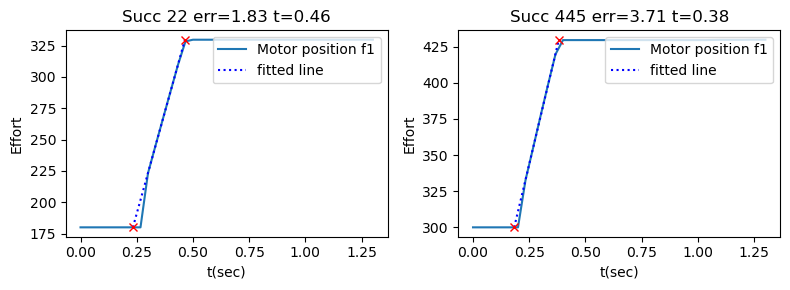

In [15]:
n_rows = 1
n_cols = 2
fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(8, 3))


# TODO Plot original data and fitted line (see slides)
#  TODO: Put the end time value and error in the title

print(pt_start_successful)
print(pt_end_successful[0])

# plot 1 create plot 
axs2[0].plot(ts, data_all[rows_to_use[0], :], label='Motor position f1')
# create dotted blue line
axs2[0].plot([pt_start_successful[0], pt_end_successful[0]], [pt_start_successful[1], pt_end_successful[1]], 'b:', label='fitted line')
# create red x marks
axs2[0].plot([pt_start_successful[0], pt_end_successful[0]], [pt_start_successful[1], pt_end_successful[1]], marker='x', markerfacecolor='red', markeredgecolor='red', linestyle='')
# create legend
axs2[0].legend(loc='upper right')
# set title and x and y labels
axs2[0].set_title(f'Succ {rows_to_use[0]} err={np.round(err_successful, 2)} t={np.round(pt_end_successful[0], 2)}')
axs2[0].set_ylabel('Effort')
axs2[0].set_xlabel('t(sec)')

# plot 2 create plot 
axs2[1].plot(ts, data_all[rows_to_use[1], :], label='Motor position f1')
# create dotted blue line
axs2[1].plot([pt_start_failed[0], pt_end_failed[0]], [pt_start_failed[1], pt_end_failed[1]], 'b:', label='fitted line')
# create red x marks
axs2[1].plot([pt_start_failed[0], pt_end_failed[0]], [pt_start_failed[1], pt_end_failed[1]], marker='x', markerfacecolor='red', markeredgecolor='red', linestyle='')
# create legend
axs2[1].legend(loc='upper right')
# set title and x and y labels
axs2[1].set_title(f'Succ {rows_to_use[1]} err={np.round(err_failed, 2)} t={np.round(pt_end_failed[0], 2)}')
axs2[1].set_ylabel('Effort')
axs2[1].set_xlabel('t(sec)')

plt.tight_layout()


In [16]:
grader.check("Plot")

Plot results: All test cases passed!

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [17]:

# List of names (creates a set)
worked_with_names = {"N/A"}
# List of URLS I25 (creates a set)
websites = {"Windows CoPilot (for asking about matplotlib arguments such as linestyle, 'b:', etc), https://numpy.org"}
# Approximate number of hours, including lab/in-class time
hours = 1.5

In [18]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Do a restart then run all to make sure everything runs ok and that the plots are showing
- Save the file (no black dot to the right of the name)
- Submit just this .ipynb file through gradescope, Lecture activity 4, fitting
- You do NOT need to submit the data file - we will supply it
- Where there are given variable/file names (eg, foo = ...) DON'T change those, or the autograder will fail

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Most likely failure for this assignment is not naming the data directory and files correctly; capitalization matters for the Gradescope grader. 

Second most likely cause for failure is reading in any files but Data/Motor position f1.csv. (Make sure when you copied your code over you didn't accidentally include code that reads in other files).

Third most likely cause is re-using the variable names used by the autograder (eg, reusing ts = )
